In [2]:
import numpy as np
import numpy.random as ndm
import torch
from torch import nn
import pandas as pd
#import matplotlib.pyplot as plt
from data_generator import generate_case_3
from data_generator import generate_case_31
from g_deep import g_D
from CCP_estimation import CCP_est
from I_spline import I_S
from Least_FD import LFD
from g_dcp import g_DCP3
from Theta_estimate import Theta_est
from zeta_estimate import zeta_est
from iteration_dcp import Est_dcp2
from Least_FDcp import LFDCP

In [20]:
def set_seed(seed):
    np.random.seed(seed) 
    torch.manual_seed(seed) 

set_seed(12)
tau = 10
p = 3 
n = 1000
corr = 0.5 
n_layer = 3
n_node = 64
n_epoch = 200 #
Set_lr = np.array([2.8e-4, 3.2e-4, 4.2e-4]) #learning rate
n_lr = 5e-4
Theta = [-1, 2]
zeta = 2

#dim_x = X_test.shape[0]
u_value = np.array(np.linspace(0, tau, 50), dtype="float32") 
Lambda_true = np.sqrt(u_value) /5
m = 10 
nodevec = np.array(np.linspace(0, tau, m+2), dtype="float32")

m0 = 4 
nodevec0 = np.array(np.linspace(0, 2, m0+2), dtype="float32")

node_D = np.array([35, 30, 30])   #deep
lr_D = np.array([4e-4, 4e-4, 4e-4])

In [21]:
test_data = generate_case_31(200, corr, Theta, zeta)
X_test = test_data['X']
Z_2_test = test_data['Z_2']
g_true = test_data['g_X']
h_true = test_data['h_X']
Res_true = test_data['g_X_C']
print(np.mean(test_data['De']))

0.36


In [22]:
from g_Lcp import g_LCP
from iteration_lcp import Est_Lcp
from Least_FDLcp import LFDLCP
Theta = [-1, 2]
G_test_linear = []
H_test_linear = []
Res_test_linear = []
ThetaL = []
zetaL = []
C_linear = []
Re_G_linear = []
Re_H_linear = []
Re_Res_linear = []
Info1_linear = []
Info2_linear = []
for b in range(200):
    print('n=', n, 'b=', b)
    set_seed(1924 + b)
    c0 = np.array(0.1*np.ones(m+p), dtype="float32")
    Theta0 = np.array([0,1], dtype='float32')
    train_data = generate_case_31(1000, 0.5, Theta, zeta)
    resultL = Est_Lcp(train_data,X_test,Z_2_test,Theta,Theta0,nodevec,m,c0)
    Theta_resL = resultL['Theta'] # vector to add row by row
    ThetaL.append(Theta_resL)
    zeta_resL = resultL['zeta']
    zetaL.append(zeta_resL)
    C_resL = resultL['c']
    C_linear.append(C_resL)
    g_test_resL = resultL['g_test']
    G_test_linear.append(g_test_resL) # vector to add row by row
    h_test_resL = resultL['h_test']
    H_test_linear.append(h_test_resL) # vector to add row by row
    Res_test_resL = resultL['Res_test']
    Res_test_linear.append(Res_test_resL) # vector to add row by row

    Re_G_linear.append(np.sqrt(np.mean((g_test_resL-np.mean(g_test_resL)-g_true)**2)/np.mean(g_true**2))) #loss of g(x)
    Re_H_linear.append(np.sqrt(np.mean((h_test_resL-np.mean(h_test_resL)-h_true)**2)/np.mean(h_true**2)))
    Re_Res_linear.append(np.sqrt(np.mean((Res_test_resL-np.mean(Res_test_resL)-Res_true)**2)/np.mean(Res_true**2)))

    Res_trainL = resultL['Res_train']
    U_train = train_data['U']
    Lambda_U_resL = I_S(m,resultL['c'],U_train,nodevec)
    ab = LFDLCP(train_data,Lambda_U_resL,Res_trainL,Theta_resL,zeta_resL)
    se1L = ab['se1']
    Info1_linear.append(se1L)
    se2L = ab['se2']
    Info2_linear.append(se2L)
     
Error_g_lcp = np.mean(np.array(G_test_linear), axis=0) - g_true
Error_h_lcp = np.mean(np.array(H_test_linear), axis=0) - h_true
Error_Res_lcp = np.mean(np.array(Res_test_linear), axis=0) - Res_true
Theta_lcp = np.mean(np.array(ThetaL),axis=0)
zeta_lcp = np.mean(np.array(zetaL))
Sd_G_linear = (np.sqrt(np.mean((Re_G_linear-np.mean(Re_G_linear))**2)))
Sd_H_linear = (np.sqrt(np.mean((Re_H_linear-np.mean(Re_H_linear))**2)))
Sd_Res_linear = (np.sqrt(np.mean((Re_Res_linear-np.mean(Re_Res_linear))**2)))
ThetaL1 = np.array(ThetaL)[:,0]
ThetaL2 = np.array(ThetaL)[:,1]
Bias1_linear = (np.mean(np.array(ThetaL1))-Theta[0])
Bias2_linear = (np.mean(np.array(ThetaL2))-Theta[1])
Sse1_linear = (np.sqrt(np.mean((np.array(ThetaL1)-np.mean(np.array(ThetaL1)))**2)))
Sse2_linear = (np.sqrt(np.mean((np.array(ThetaL2)-np.mean(np.array(ThetaL2)))**2)))
Ese1_linear = (np.mean(np.array(Info1_linear)))
Cp1_linear = (np.mean((np.array(ThetaL1)-1.96*np.array(Info1_linear)<=Theta[0])*\
                       (Theta[0]<=np.array(ThetaL1)+1.96*np.array(Info1_linear))))
Ese2_linear = (np.mean(np.array(Info2_linear)))
Cp2_linear = (np.mean((np.array(ThetaL2)-1.96*np.array(Info2_linear)<=Theta[1])*\
                       (Theta[1]<=np.array(ThetaL2)+1.96*np.array(Info2_linear))))
Bias_zetaL = np.mean(np.array(zetaL))-zeta
Sd_zetaL = np.mean(np.sqrt((np.array(zetaL)-np.mean(np.array(zetaL)))**2))
zetaLS = np.sort(np.array(zetaL))
Length_zetaL = zetaLS[195]-zetaLS[5]  #95% interval's length
print('Estimation for reg para and change point para:')
print('Theta: ', Theta_lcp)
print('zeta: ', zeta_lcp)
print('Estimation for Re and Sd of deep function:')
print('Re_g: ', np.mean(Re_G_linear))
print('Re_h: ', np.mean(Re_H_linear))
print('Re_total: ', np.mean(Re_Res_linear))
print('SdRe_g: ', Sd_G_linear)
print('SdRe_h: ', Sd_H_linear)
print('SdRe_total: ', Sd_Res_linear)
print('Inference for beta:')
print('Bias1:', Bias1_linear)
print('Sse1: ', Sse1_linear)
print('Ese1: ', Ese1_linear)
print('CP1: ', Cp1_linear)
print('Inference for gamma:')
print('Bias2:', Bias2_linear)
print('Sse2: ', Sse2_linear)
print('Ese2: ', Ese2_linear)
print('CP2: ', Cp2_linear)
print('Inference for zeta:')
print('Bias_zeta:', Bias_zetaL)
print('Length_zeta:', Length_zetaL)
print('Sd_zeta:', Sd_zetaL)

n= 1000 b= 0
n= 1000 b= 1
n= 1000 b= 2
n= 1000 b= 3
n= 1000 b= 4
n= 1000 b= 5
n= 1000 b= 6
n= 1000 b= 7
n= 1000 b= 8
n= 1000 b= 9
n= 1000 b= 10
n= 1000 b= 11
n= 1000 b= 12
n= 1000 b= 13
n= 1000 b= 14
n= 1000 b= 15
n= 1000 b= 16
n= 1000 b= 17
n= 1000 b= 18
n= 1000 b= 19
n= 1000 b= 20
n= 1000 b= 21
n= 1000 b= 22
n= 1000 b= 23
n= 1000 b= 24
n= 1000 b= 25
n= 1000 b= 26
n= 1000 b= 27
n= 1000 b= 28
n= 1000 b= 29
n= 1000 b= 30
n= 1000 b= 31
n= 1000 b= 32
n= 1000 b= 33
n= 1000 b= 34
n= 1000 b= 35
n= 1000 b= 36
n= 1000 b= 37
n= 1000 b= 38
n= 1000 b= 39
n= 1000 b= 40
n= 1000 b= 41
n= 1000 b= 42
n= 1000 b= 43
n= 1000 b= 44
n= 1000 b= 45
n= 1000 b= 46
n= 1000 b= 47
n= 1000 b= 48
n= 1000 b= 49
n= 1000 b= 50
n= 1000 b= 51
n= 1000 b= 52
n= 1000 b= 53
n= 1000 b= 54
n= 1000 b= 55
n= 1000 b= 56
n= 1000 b= 57
n= 1000 b= 58
n= 1000 b= 59
n= 1000 b= 60
n= 1000 b= 61
n= 1000 b= 62
n= 1000 b= 63
n= 1000 b= 64
n= 1000 b= 65
n= 1000 b= 66
n= 1000 b= 67
n= 1000 b= 68
n= 1000 b= 69
n= 1000 b= 70
n= 1000 b= 71
n=

In [18]:
G_test_deep = []; H_test_deep = []; Res_test_deep = []
ThetaM = []; zetaM = []; C_deep = []
Info1_deep = []; Info2_deep = []; Re_G_deep = []; Re_H_deep = []; Re_Res_deep = []
for b in range(200):
    print('n=', n, 'b=', b )
    set_seed(1924 + b)
    c0 = np.array(0.1*np.ones(m+p), dtype="float32")
    Theta0 = np.array([0,1], dtype='float32')
    train_data = generate_case_31(1000, corr, Theta, zeta)  #g and h are deep function
    U_train = train_data['U']
    De_train = train_data['De']
    Z_train = train_data['Z']
    Z_2_train = train_data['Z_2']
    
    # Estimation
    result = Est_dcp2(train_data,X_test,Z_2_test,Theta,Theta0,3,64,3.2e-4,200,nodevec,m,c0)

    # record the results
    Theta_res = result['Theta'] # vector to add row by row
    ThetaM.append(Theta_res)
    zeta_res = result['zeta'] # change point
    zetaM.append(zeta_res)
    C_res = result['c'] # baseline cumulative hazard
    C_deep.append(C_res)
    
    # test data to calculate Re and Sd_Re for g and h
    g_test_res = result['g_test'] 
    G_test_deep.append(g_test_res) # vector to add row by row
    h_test_res = result['h_test']
    H_test_deep.append(h_test_res) # vector to add row by row
    Res_test_res = result['Res_test']
    Res_test_deep.append(Res_test_res) # vector to add row by row
    Re_G_deep.append(np.sqrt(np.mean((g_test_res-np.mean(g_test_res)-g_true)**2)/np.mean(g_true**2))) #Re loss of g(x)
    Re_H_deep.append(np.sqrt(np.mean((h_test_res-np.mean(h_test_res)-h_true)**2)/np.mean(h_true**2)))
    Re_Res_deep.append(np.sqrt(np.mean((Res_test_res-np.mean(Res_test_res)-Res_true)**2)/np.mean(Res_true**2)))

    # Calculataion of the score and information
    Z1 = Z_train
    Z2 = Z_train*(Z_2_train>zeta_res)
    a_b1 = LFDCP(Z1,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=50,n_lr=1e-3,n_epoch=200)
    a_b2 = LFDCP(Z2,train_data,I_S(m,result['c'],U_train,nodevec),result['Res_train'],result['Theta'],\
             result['zeta'],n_layer=3,n_node=50,n_lr=1e-3,n_epoch=200)
    Z_train1 = np.vstack((Z_train, Z_train*(Z_2_train>zeta)))
    Z_train1 = Z_train1.T  
    h_v_deep = I_S(m,result['c'],U_train,nodevec) * np.exp(Z_train1@result['Theta'] + result['Res_train'])
    Q_y_deep = h_v_deep * (De_train * np.exp(-h_v_deep)/(1-np.exp(-h_v_deep)+1e-8) - (1-De_train))
    Info = np.zeros((2,2))
    Info[0,0] = np.mean(Q_y_deep**2 * (Z1-a_b1)**2)
    Info[1,1] = np.mean(Q_y_deep**2 * (Z2-a_b2)**2)
    Info[0,1] = np.mean(Q_y_deep**2 * (Z1-a_b1)*(Z2-a_b2))
    Info[1,0] = Info[0,1]
    Sigma = np.linalg.inv(Info)/n
    se1 = np.sqrt(Sigma[0,0])
    Info1_deep.append(se1)
    se2 = np.sqrt(Sigma[1,1])
    Info2_deep.append(se2)


#Error_g_dcp = np.mean(np.array(G_test_deep), axis=0) - g_true
#Error_h_dcp = np.mean(np.array(H_test_deep), axis=0) - h_true
#Error_Res_dcp = np.mean(np.array(Res_test_deep), axis=0) - Res_true
Theta_dcp = np.mean(np.array(ThetaM),axis=0)
zeta_dcp = np.mean(np.array(zetaM))
Sd_G_deep = (np.sqrt(np.mean((Re_G_deep-np.mean(Re_G_deep))**2)))
Sd_H_deep = (np.sqrt(np.mean((Re_H_deep-np.mean(Re_H_deep))**2)))
Sd_Res_deep = (np.sqrt(np.mean((Re_Res_deep-np.mean(Re_Res_deep))**2)))
ThetaM1 = np.array(ThetaM)[:,0]
ThetaM2 = np.array(ThetaM)[:,1]
Bias1_deep = (np.mean(np.array(ThetaM1))-Theta[0])
Sse1_deep = (np.sqrt(np.mean((np.array(ThetaM1)-np.mean(np.array(ThetaM1)))**2)))
Ese1_deep = (np.mean(np.array(Info1_deep)))
Cp1_deep = (np.mean((np.array(ThetaM1)-1.96*np.array(Info1_deep)<=Theta[0])*\
                       (Theta[0]<=np.array(ThetaM1)+1.96*np.array(Info1_deep))))
Bias2_deep = (np.mean(np.array(ThetaM2))-Theta[1])
Sse2_deep = (np.sqrt(np.mean((np.array(ThetaM2)-np.mean(np.array(ThetaM2)))**2)))
Ese2_deep = (np.mean(np.array(Info2_deep)))
Cp2_deep = (np.mean((np.array(ThetaM2)-1.96*np.array(Info2_deep)<=Theta[1])*\
                       (Theta[1]<=np.array(ThetaM2)+1.96*np.array(Info2_deep))))
Bias_zeta = np.mean(np.array(zetaM))-zeta
Sd_zeta = np.mean(np.sqrt((np.array(zetaM)-np.mean(np.array(zetaM)))**2))
zetaMS = np.sort(np.array(zetaM))
Length_zeta = zetaMS[195]-zetaMS[5]  #95% interval's length
#print(Error_g_dcp)
#print(Error_h_dcp)
#print(Error_Res_dcp)
print('Estimation for reg para and change point para:')
print('Theta: ', Theta_dcp)
print('zeta: ', zeta_dcp)
print('Estimation for Re and Sd of deep function:')
print('Re_g: ', np.mean(Re_G_deep))
print('Re_h: ', np.mean(Re_H_deep))
print('Re_total: ', np.mean(Re_Res_deep))
print('SdRe_g: ', Sd_G_deep)
print('SdRe_h: ', Sd_H_deep)
print('SdRe_total: ', Sd_Res_deep)
print('Inference for beta:')
print('Bias1:', Bias1_deep)
print('Sse1: ', Sse1_deep)
print('Ese1: ', Ese1_deep)
print('Cp1: ', Cp1_deep)
print('Inference for gamma:')
print('Bias2:', Bias2_deep)
print('Sse2: ', Sse2_deep)
print('Ese2: ', Ese2_deep)
print('Cp2: ', Cp2_deep)
print('Inference for zeta:')
print('Bias_zeta:', Bias_zeta)
print('Length_zeta:', Length_zeta)
print('Sd_zeta:', Sd_zeta)

n= 2000 b= 0
n= 2000 b= 1
n= 2000 b= 2
n= 2000 b= 3
n= 2000 b= 4
n= 2000 b= 5
n= 2000 b= 6
n= 2000 b= 7
n= 2000 b= 8
n= 2000 b= 9
n= 2000 b= 10
n= 2000 b= 11
n= 2000 b= 12
n= 2000 b= 13
n= 2000 b= 14
n= 2000 b= 15
n= 2000 b= 16
n= 2000 b= 17
n= 2000 b= 18
n= 2000 b= 19
n= 2000 b= 20
n= 2000 b= 21
n= 2000 b= 22
n= 2000 b= 23
n= 2000 b= 24
n= 2000 b= 25
n= 2000 b= 26
n= 2000 b= 27
n= 2000 b= 28
n= 2000 b= 29
n= 2000 b= 30
n= 2000 b= 31
n= 2000 b= 32
n= 2000 b= 33
n= 2000 b= 34
n= 2000 b= 35
n= 2000 b= 36
n= 2000 b= 37
n= 2000 b= 38
n= 2000 b= 39
n= 2000 b= 40
n= 2000 b= 41
n= 2000 b= 42
n= 2000 b= 43
n= 2000 b= 44
n= 2000 b= 45
n= 2000 b= 46
n= 2000 b= 47
n= 2000 b= 48
n= 2000 b= 49
n= 2000 b= 50
n= 2000 b= 51
n= 2000 b= 52
n= 2000 b= 53
n= 2000 b= 54
n= 2000 b= 55
n= 2000 b= 56
n= 2000 b= 57
n= 2000 b= 58
n= 2000 b= 59
n= 2000 b= 60
n= 2000 b= 61
n= 2000 b= 62
n= 2000 b= 63
n= 2000 b= 64
n= 2000 b= 65
n= 2000 b= 66
n= 2000 b= 67
n= 2000 b= 68
n= 2000 b= 69
n= 2000 b= 70
n= 2000 b= 71
n=

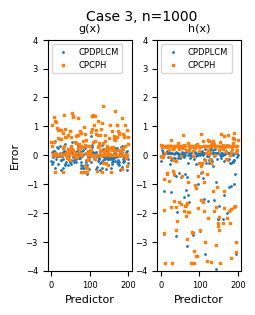

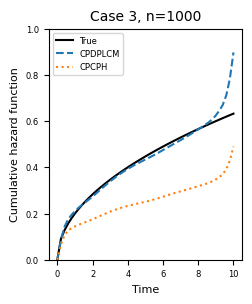

In [38]:
import matplotlib.pyplot as plt
dim_x = X_test.shape[0]
u_value = np.array(np.linspace(0, tau, 50), dtype="float32") 
Lambda_true = np.sqrt(u_value) /5

fig1 = plt.figure(figsize=(2.5, 3))  #prediction error of g and h
fig1.suptitle("Case 3, n=1000",fontsize=10) 
ax1_1 = fig1.add_subplot(1, 2, 1)
plt.ylim(-4,4) 
ax1_1.set_title("g(x)",fontsize=8) 
ax1_1.set_xlabel("Predictor",fontsize=8) 
ax1_1.set_ylabel("Error",fontsize=8) 
ax1_1.tick_params(axis='both',labelsize=6)

ax1_2 = fig1.add_subplot(1, 2, 2)
plt.ylim(-4,4) 
ax1_2.set_title("h(x)",fontsize=8)
ax1_2.set_xlabel("Predictor",fontsize=8)
# ax1_2.set_ylabel("Error",fontsize=8)
ax1_2.tick_params(axis='both',labelsize=6)
plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.3,hspace=0.15)

#cumulative hazard
fig2 = plt.figure(figsize=(2.5, 3))  
ax2_1 = fig2.add_subplot(1, 1, 1)
plt.ylim(0,1) 
ax2_1.set_title("Case 3, n=1000", fontsize=10)
ax2_1.set_xlabel("Time",fontsize=8) 
ax2_1.set_ylabel("Cumulative hazard function",fontsize=8) 
ax2_1.tick_params(axis='both',labelsize=6)
ax2_1.plot(u_value, Lambda_true, color='k', label='True')
ax2_1.legend(loc='upper left', fontsize=6) 


Error_G_deep = np.mean(np.array(G_test_deep), axis=0) - g_true
Error_H_deep = np.mean(np.array(H_test_deep), axis=0) - h_true
Error_Res_deep = np.mean(np.array(Res_test_deep), axis=0) - Res_true

ax1_1.scatter(np.arange(dim_x), Error_G_deep, s=1, marker='o', label='CPDPLCM')
ax1_1.legend(loc='upper left', fontsize=6)
ax1_2.scatter(np.arange(dim_x), Error_H_deep, s=1, marker='o', label='CPDPLCM')
ax1_2.legend(loc='upper left', fontsize=6)
#ax1_3.scatter(np.arange(dim_x), Error_Res_deep, s=1, marker='o', label='CPDPLCM')
#ax1_3.legend(loc='upper left', fontsize=4)
ax2_1.plot(u_value, I_S(m,np.mean(np.array(C_deep), axis=0),u_value,nodevec), label='CPDPLCM', linestyle='--')
ax2_1.legend(loc='upper left', fontsize=6)


Error_G_L = np.mean(np.array(G_test_linear), axis=0) - g_true
Error_H_L = np.mean(np.array(H_test_linear), axis=0) - g_true
Error_Res_L = np.mean(np.array(Res_test_linear), axis=0) - g_true

ax1_1.scatter(np.arange(dim_x), Error_G_L, s=1, marker='s', label='CPCPH')
ax1_1.legend(loc='upper left', fontsize=6)
ax1_2.scatter(np.arange(dim_x), Error_H_L, s=1, marker='s', label='CPCPH')
ax1_2.legend(loc='upper left', fontsize=6)
#ax1_3.scatter(np.arange(dim_x), Error_Res_L, s=1, marker='s', label='CPCPH')
#ax1_3.legend(loc='upper left', fontsize=4)
ax2_1.plot(u_value, I_S(m,np.mean(np.array(C_linear), axis=0),u_value,nodevec), label='CPCPH', linestyle=':')
ax2_1.legend(loc='upper left', fontsize=6)



In [ ]:
fig1.savefig('D1.png', dpi=400, bbox_inches='tight')
fig2.savefig('LD1.png', dpi=400, bbox_inches='tight')